In [ ]:
import numpy as np

In [ ]:
class UTIL():
    def __init__(self,rel,T,val,gamma): #Always use this fun --> util_calc
        self.R=rel
        self.T=T
        self.val=val
        self.gamma=gamma
        self.lst=[]
    def fun(self,a,b,c,k,n): # Always use this function 1st
        # kth_user: 0 -> O_f and 1-> O_bar(f) in R[k,0/1]
        if(k==n):
            self.lst.append([a+b,c])
            return
        self.fun(a*self.T[k]*self.R[k,0],b*self.T[k]*(1-self.R[k,1]),c*((1-self.R[k,1])/self.R[k,0]),k+1,n) #flagged by user k+1
        self.fun(a*self.T[k]*(1-self.R[k,0]),b*self.T[k]*self.R[k,1],c*self.R[k,1]/(1-self.R[k,0]),k+1,n)
        self.fun(a*(1-self.T[k]),b*(1-self.T[k]),c,k+1,n)
    def util_calc(self):
        sum=0
        j=0
        for i in self.lst:
            sum+= i[0]*max(0,(1/(1+i[1]))*self.val[j]-self.gamma)
            j+=1
        return sum

In [ ]:
class BinaryTree():
    def __init__(self,layers,p):
        self.layers=layers
        P=np.zeros((2**layers-1,2**layers-1))
        for i in range(0,2**(layers-1)-1): #adjacency matrix
            P[2*i+1:2*i+3,i]=p
        self.P=P
        self.p=p

    def affectednodes(self,N): # N= [0,1] => [2,3,4], [0,0,0.5...]
        # Gives samples of infected nodes indices
        # also gives array (all_nodes_length) of probabilities of influence
        probabilities=np.sum(self.P[:,N],axis=1) #pij= prob of jth column infecting i
        random=np.random.random(self.P.shape[0])
        affected=np.argwhere(probabilities>random).reshape(-1)
        return affected,probabilities

    def fut_val_calc(self,N): # for getting self.val for UTIL class # N=[1,4,5,7,8] => 3^5 length list
        stack=np.zeros(3**len(N))
        lst=[]
        if self.p!=0.5:
            for i in N:
                k=np.ceil(np.log2(i+2))
                lst.append(2*self.p*((2*self.p)**(self.layers-k)-1)/(2*self.p-1))
        else:
            for i in N:
                k=np.ceil(np.log2(i+2))
                lst.append(self.layers-k)

        for l in range(3,3**len(N)+1):
            tr=1
            l_copy=l
            while(l_copy%3==0):
                stack[l-3**(tr-1):l]+=lst[len(N)-tr]
                l_copy/=3
                tr+=1
        return sum(lst)*np.ones(3**len(N))-stack # for N= [] => [0]

    def val_calc(self,N): #  N=[1,4,5] => [val(1),val(4),val(5)]
        lst=[]
        if self.p!=0.5:
            for i in N:
                k=np.ceil(np.log2(i+2))
                lst.append(2*self.p*((2*self.p)**(self.layers-k)-1)/(2*self.p-1))
        else:
            for i in N:
                k=np.ceil(np.log2(i+2))
                lst.append(self.layers-k)
        return lst
tree=BinaryTree(3,0.5)
nodes=tree.affectednodes([5])[0]
print(nodes)
# tree.val_calc([0,5])

[]


In [ ]:
class News(): ## all news array at t
    ## Flags and rel are numpy arrays
    def __init__(self,tree,affected,rel,labels,flags,beta,gamma): #fake=0 and true=1, eg: self.aff=affected= [[1],[1,2,3],[2,4,6]]
                                                                  #in self.flags: flags => 1 & not flags => 0
        self.tree=tree
        self.aff=affected
        self.labels=labels
        self.rel=rel
        self.flags=flags
        self.beta=beta
        self.gamma=gamma

    def infected(self): # [[1],[1,2,3],[2,4,6]] => [[3,4],[5,6],[7]], indices of new infected nodes
        #flags_allnews: [3,4] flags, [5,6] flags
        new_inf=[]
        flags=self.flags.copy()
        k=0
        for i in self.aff:
            flag_rel=self.rel[:,int(self.labels[k])]
            a=self.tree.affectednodes(i)[0]
            new_inf.append(a)
            random=np.random.random(len(a))
            mult=flag_rel[a]>random
            label=self.labels[k]
            flags[k,a]=np.logical_xor(mult,label)
            k+=1

        return new_inf,flags

    def expected_util(self): # expected util_t, P_t for all news at t
        P_t=[]
        k=0
        util=np.zeros(self.flags.shape[0])
        for i in self.flags:
            flagged=np.argwhere(i==1).reshape(-1)
            not_flagged=np.argwhere(i==0).reshape(-1)
            numerator=np.prod(self.rel[flagged,0])*np.prod(1-self.rel[not_flagged,0])*(self.beta)
            den=numerator+(1-self.beta)*np.prod(1-self.rel[flagged,1])*np.prod(self.rel[not_flagged,1])
            prob=numerator/den
            P_t.append(prob)
            k+=1

        for i in range(util.shape[0]):
            util[i]=P_t[i]*sum(tree.val_calc(self.aff[i]))-self.gamma
        return util,np.array(P_t) #both numpy arrays

#tree=BinaryTree(layers=5,p=0.8)
#news=News(tree,affected=[[2,3],[1,2]],rel=np.array([[0.8,0.8]*31]).reshape(31,2),labels=[1,0],flags=np.random.choice([-1,0,1],62,p=[0.6,0.25,0.15]).reshape(2,-1),beta=0.5)

#print(news.infected())

In [ ]:
class Greedy():
    def __init__(self,news):
        self.news=news # UTIL(): rel,T,val,gamma as input :rel only for future infected

    def select_news(self): #Gives news indices to be sent to Oracle
        fut_utils=[]
        util_now=self.news.expected_util()
        util_t=util_now[0]
        P_t=util_now[1]
        return np.argwhere(util_t>0).reshape(-1)

tree=BinaryTree(layers=5,p=0.8)
news=News(tree,affected=[[29,3],[1,2]],rel=np.array([[0.8,0.8]*31]).reshape(31,2),labels=[1,0],flags=np.random.choice([-1,0,1],62,p=[0.6,0.25,0.15]).reshape(2,-1),beta=0.5,gamma=0.05)

Greedy(news).select_news()

array([0, 1])

In [ ]:
class Algorithm():
    def __init__(self,news):
        self.news=news # UTIL(): rel,T,val,gamma as input :rel only for future infected

    def select_news(self): #Gives news indices to be sent to Oracle
        fut_utils=[]
        util_now=self.news.expected_util()
        util_t=np.array(util_now[0])
        P_t=util_now[1]
        util_next=[]
        k=0

        for i in self.news.aff:
            inf=self.news.tree.affectednodes(i)[1] #gets prob of infection
            inf_arg=np.argwhere(inf>0).reshape(-1) #arguments of future infected nodes with non-zer prob
            local_rel=self.news.rel[inf_arg]
            fut_val=self.news.tree.fut_val_calc(inf_arg) #val for future nodes
            U=UTIL(local_rel,self.news.tree.p*np.ones(len(inf_arg)),fut_val,self.news.gamma)
            U.fun(P_t[k],1-P_t[k],P_t[k],0,len(inf_arg))
            util_next.append(U.util_calc())
            k+=1
        util_next=np.array(util_next)

        # if len(np.argwhere((util_next>util_t) & (util_t>0)).reshape(-1)) > 0:
        #     print('Yes!')
        print(util_next, util_t)

        return np.argwhere((util_t>=util_next) & (util_t>0)).reshape(-1)


tree=BinaryTree(layers=3,p=1)
news=News(tree,affected=[[0]],rel=np.array([[0.9999999,0.999999999]*31]).reshape(31,2),labels=[0],flags=-1*np.ones(31).reshape(1,31),beta=0.5,gamma=2.5)

print(Algorithm(news).select_news()) # => 0.75 Utility
print(Greedy(news).select_news()) # => 0.5 Utility

[0.75] [0.5]
[]
[0]


In [ ]:
layers=6
diff_prob=0.7
tree=BinaryTree(layers,diff_prob)
beta=0.5
gamma=2.5
affected=[]


ind=np.random.choice([0,1,2],2**layers-1,p=[0.005,0.005,0.99])
t=np.array([[0.65,0.65],[0.9,0.1],[0.9999,0.9999]])
rel=t[ind]

u_1=[]
u_2=[]
u_3=[]

for t in range(10):
    if (t==0):
        affected=[[np.random.randint(0,2**(layers//1.5)-1)],[np.random.randint(0,2**(layers//1.5)-1)]]
        labels=np.random.choice([True,False],2,p=[1-beta,beta])
        flags=-1*np.ones((2,2**layers-1))
        util_max=max(np.sum((1-np.array(labels))*np.array([sum(tree.val_calc(i)) for i in affected]))-len(np.argwhere(labels==0).reshape(-1))*gamma,0)
        util_algo=0

        util_greedy=0

        affected_1=affected.copy()
        labels_1=labels.copy()
        flags_1=flags.copy()
        continue
    else:
        util_1.append(util_max)

    empty_indices=[i for i in range(len(affected)) if (len(affected[i])==0)]
    labels= [labels[i] for i in range(len(labels)) if i not in empty_indices]
    affected= [affected[i] for i in range(len(affected)) if i not in empty_indices]
    flags= np.delete(flags,empty_indices,0)

    empty_indices_1=[i for i in range(len(affected_1)) if (len(affected_1[i])==0)]
    labels_1= [labels_1[i] for i in range(len(labels_1)) if i not in empty_indices_1]
    affected_1= [affected_1[i] for i in range(len(affected_1)) if i not in empty_indices_1]
    flags_1= np.delete(flags_1,empty_indices_1,0)




    # Sending to Oracle!
    news=News(tree,affected,rel,labels,flags,beta,gamma)
    indices=Algorithm(news).select_news()

    # Sending to Oracle_Greedy!
    news_1=News(tree,affected_1,rel,labels_1,flags_1,beta,gamma)
    indices_1=Greedy(news_1).select_news()

    # print(t,labels,affected,indices,indices_1)

    util_algo+=np.sum((1-np.array(labels)[indices])*np.array([sum(tree.val_calc(affected[i])) for i in indices])) - gamma*len(indices)
    labels= [labels[i] for i in range(len(labels)) if i not in indices]  # list
    affected= [affected[i] for i in range(len(affected)) if i not in indices] # list of lists
    flags= np.delete(flags,indices,0) # array
    util_2.append(util_algo)


    util_greedy+=np.sum((1-np.array(labels_1)[indices_1])*np.array([sum(tree.val_calc(affected_1[i])) for i in indices_1])) - gamma*len(indices_1)
    labels_1= [labels_1[i] for i in range(len(labels_1)) if i not in indices_1]  # list
    affected_1= [affected_1[i] for i in range(len(affected_1)) if i not in indices_1] # list of lists
    flags_1= np.delete(flags_1,indices_1,0) # array
    util_3.append(util_greedy)

    # News infection

    news=News(tree,affected,rel,labels,flags,beta,gamma)
    affected,flags=news.infected()

    news_1=News(tree,affected_1,rel,labels_1,flags_1,beta,gamma)
    affected_1,flags_1=news_1.infected()


    if (t<6 and t>0):
        new=np.random.randint(0,2**(layers//1.5),2)
        new_labels=np.random.choice([True,False],2,p=[1-beta,beta])

        flags=np.vstack((flags,-1*np.ones((2,2**layers-1))))
        labels=np.concatenate((labels,new_labels))
        affected.extend([[item] for item in new])

        flags_1=np.vstack((flags_1,-1*np.ones((2,2**layers-1))))
        labels_1=np.concatenate((labels_1,new_labels))
        affected_1.extend([[item] for item in new])

        util_max+= max(np.sum((1-np.array(new_labels))*np.array([sum(tree.val_calc([i])) for i in new]))-len(np.argwhere(new_labels==0).reshape(-1))*gamma,0)


NameError: name 'util_1' is not defined

#**Generalized Version**

In [ ]:
iter=40

layers=7
diff_prob=0.6
tree=BinaryTree(layers,diff_prob)
beta=0.6
gamma=2.5
affected=[]


ind=np.random.choice([0,1,2],2**layers-1,p=[0.005, 0.005, 0.99])
t=np.array([[0.65,0.65],[0.9,0.1],[0.9999,0.9999]])
rel=t[ind]

u_1=[]
u_2=[]
u_3=[]
for repeat in range(iter):
    util_1=[0]
    util_2=[0]
    util_3=[0]
    for t in range(10):
        if (t==0):
            affected=[[np.random.randint(0,2**(layers//1.5)-1)],[np.random.randint(0,2**(layers//1.5)-1)]]
            labels=np.random.choice([True,False],2,p=[1-beta,beta])
            flags=-1*np.ones((2,2**layers-1))
            util_max=max(np.sum((1-np.array(labels))*np.array([sum(tree.val_calc(i)) for i in affected]))-len(np.argwhere(labels==0).reshape(-1))*gamma,0)
            util_algo=0

            util_greedy=0

            affected_1=affected.copy()
            labels_1=labels.copy()
            flags_1=flags.copy()
            continue
        else:
            util_1.append(util_max)

        empty_indices=[i for i in range(len(affected)) if (len(affected[i])==0)]
        labels= [labels[i] for i in range(len(labels)) if i not in empty_indices]
        affected= [affected[i] for i in range(len(affected)) if i not in empty_indices]
        flags= np.delete(flags,empty_indices,0)

        empty_indices_1=[i for i in range(len(affected_1)) if (len(affected_1[i])==0)]
        labels_1= [labels_1[i] for i in range(len(labels_1)) if i not in empty_indices_1]
        affected_1= [affected_1[i] for i in range(len(affected_1)) if i not in empty_indices_1]
        flags_1= np.delete(flags_1,empty_indices_1,0)




        # Sending to Oracle!
        news=News(tree,affected,rel,labels,flags,beta,gamma)
        indices=Algorithm(news).select_news()

        # Sending to Oracle_Greedy!
        news_1=News(tree,affected_1,rel,labels_1,flags_1,beta,gamma)
        indices_1=Greedy(news_1).select_news()

        # print(t,labels,affected,indices,indices_1)

        util_algo+=np.sum((1-np.array(labels)[indices])*np.array([sum(tree.val_calc(affected[i])) for i in indices])) - gamma*len(indices)
        labels= [labels[i] for i in range(len(labels)) if i not in indices]  # list
        affected= [affected[i] for i in range(len(affected)) if i not in indices] # list of lists
        flags= np.delete(flags,indices,0) # array
        util_2.append(util_algo)


        util_greedy+=np.sum((1-np.array(labels_1)[indices_1])*np.array([sum(tree.val_calc(affected_1[i])) for i in indices_1])) - gamma*len(indices_1)
        labels_1= [labels_1[i] for i in range(len(labels_1)) if i not in indices_1]  # list
        affected_1= [affected_1[i] for i in range(len(affected_1)) if i not in indices_1] # list of lists
        flags_1= np.delete(flags_1,indices_1,0) # array
        util_3.append(util_greedy)

        # News infection

        news=News(tree,affected,rel,labels,flags,beta,gamma)
        affected,flags=news.infected()

        news_1=News(tree,affected_1,rel,labels_1,flags_1,beta,gamma)
        affected_1,flags_1=news_1.infected()


        if (t<6 and t>0):
            new=np.random.randint(0,2**(layers//1.5),2)
            new_labels=np.random.choice([True,False],2,p=[1-beta,beta])

            flags=np.vstack((flags,-1*np.ones((2,2**layers-1))))
            labels=np.concatenate((labels,new_labels))
            affected.extend([[item] for item in new])

            flags_1=np.vstack((flags_1,-1*np.ones((2,2**layers-1))))
            labels_1=np.concatenate((labels_1,new_labels))
            affected_1.extend([[item] for item in new])

            util_max+= max(np.sum((1-np.array(new_labels))*np.array([sum(tree.val_calc([i])) for i in new]))-len(np.argwhere(new_labels==0).reshape(-1))*gamma,0)
    if(repeat==0):
        u_1=np.array(util_1)
        u_2=np.array(util_2)
        u_3=np.array(util_3)
    else:
        u_1+=np.array(util_1)
        u_2+=np.array(util_2)
        u_3+=np.array(util_3)
    print(repeat)

u_1=np.array(u_1)/iter
u_2=np.array(u_2)/iter
u_3=np.array(u_3)/iter


# print(affected)


    # tree,affected,rel,labels,flags,beta,gamma

In [ ]:
iter=40

layers=7
diff_prob=0.6
tree=BinaryTree(layers,diff_prob)
beta=0.6
gamma=2.5
affected=[]


ind=np.random.choice([0,1,2],2**layers-1,p=[0.33,0.33,0.34])
t=np.array([[0.65,0.65],[0.1,0.9],[0.9999,0.9999]])
rel=t[ind]

u_1=[]
u_2=[]
u_3=[]
for repeat in range(iter):
    util_1=[0]
    util_2=[0]
    util_3=[0]
    for t in range(10):
        if (t==0):
            affected=[[np.random.randint(0,2**(layers//1.5)-1)],[np.random.randint(0,2**(layers//1.5)-1)]]
            labels=np.random.choice([True,False],2,p=[1-beta,beta])
            flags=-1*np.ones((2,2**layers-1))
            util_max=max(np.sum((1-np.array(labels))*np.array([sum(tree.val_calc(i)) for i in affected]))-len(np.argwhere(labels==0).reshape(-1))*gamma,0)
            util_algo=0

            util_greedy=0

            affected_1=affected.copy()
            labels_1=labels.copy()
            flags_1=flags.copy()
            continue
        else:
            util_1.append(util_max)

        empty_indices=[i for i in range(len(affected)) if (len(affected[i])==0)]
        labels= [labels[i] for i in range(len(labels)) if i not in empty_indices]
        affected= [affected[i] for i in range(len(affected)) if i not in empty_indices]
        flags= np.delete(flags,empty_indices,0)

        empty_indices_1=[i for i in range(len(affected_1)) if (len(affected_1[i])==0)]
        labels_1= [labels_1[i] for i in range(len(labels_1)) if i not in empty_indices_1]
        affected_1= [affected_1[i] for i in range(len(affected_1)) if i not in empty_indices_1]
        flags_1= np.delete(flags_1,empty_indices_1,0)




        # Sending to Oracle!
        news=News(tree,affected,rel,labels,flags,beta,gamma)
        indices=Algorithm(news).select_news()

        # Sending to Oracle_Greedy!
        news_1=News(tree,affected_1,rel,labels_1,flags_1,beta,gamma)
        indices_1=Greedy(news_1).select_news()

        # print(t,labels,affected,indices,indices_1)

        util_algo+=np.sum((1-np.array(labels)[indices])*np.array([sum(tree.val_calc(affected[i])) for i in indices])) - gamma*len(indices)
        labels= [labels[i] for i in range(len(labels)) if i not in indices]  # list
        affected= [affected[i] for i in range(len(affected)) if i not in indices] # list of lists
        flags= np.delete(flags,indices,0) # array
        util_2.append(util_algo)


        util_greedy+=np.sum((1-np.array(labels_1)[indices_1])*np.array([sum(tree.val_calc(affected_1[i])) for i in indices_1])) - gamma*len(indices_1)
        labels_1= [labels_1[i] for i in range(len(labels_1)) if i not in indices_1]  # list
        affected_1= [affected_1[i] for i in range(len(affected_1)) if i not in indices_1] # list of lists
        flags_1= np.delete(flags_1,indices_1,0) # array
        util_3.append(util_greedy)

        # News infection

        news=News(tree,affected,rel,labels,flags,beta,gamma)
        affected,flags=news.infected()

        news_1=News(tree,affected_1,rel,labels_1,flags_1,beta,gamma)
        affected_1,flags_1=news_1.infected()


        if (t<6 and t>0):
            new=np.random.randint(0,2**(layers//1.5),2)
            new_labels=np.random.choice([True,False],2,p=[1-beta,beta])

            flags=np.vstack((flags,-1*np.ones((2,2**layers-1))))
            labels=np.concatenate((labels,new_labels))
            affected.extend([[item] for item in new])

            flags_1=np.vstack((flags_1,-1*np.ones((2,2**layers-1))))
            labels_1=np.concatenate((labels_1,new_labels))
            affected_1.extend([[item] for item in new])

            util_max+= max(np.sum((1-np.array(new_labels))*np.array([sum(tree.val_calc([i])) for i in new]))-len(np.argwhere(new_labels==0).reshape(-1))*gamma,0)
    if(repeat==0):
        u_1=np.array(util_1)
        u_2=np.array(util_2)
        u_3=np.array(util_3)
    else:
        u_1+=np.array(util_1)
        u_2+=np.array(util_2)
        u_3+=np.array(util_3)
    print(repeat)

u_1=np.array(u_1)/iter
u_2=np.array(u_2)/iter
u_3=np.array(u_3)/iter


# print(affected)


    # tree,affected,rel,labels,flags,beta,gamma

In [ ]:
iter=40

layers=7
diff_prob=0.6
tree=BinaryTree(layers,diff_prob)
beta=0.6
gamma=2.5
affected=[]


ind=np.random.choice([0,1,2],2**layers-1,p=[0.45,0.45,0.1])
t=np.array([[0.65,0.65],[0.1,0.9],[0.9999,0.9999]])
rel=t[ind]

u_1=[]
u_2=[]
u_3=[]
for repeat in range(iter):
    util_1=[0]
    util_2=[0]
    util_3=[0]
    for t in range(10):
        if (t==0):
            affected=[[np.random.randint(0,2**(layers//1.5)-1)],[np.random.randint(0,2**(layers//1.5)-1)]]
            labels=np.random.choice([True,False],2,p=[1-beta,beta])
            flags=-1*np.ones((2,2**layers-1))
            util_max=max(np.sum((1-np.array(labels))*np.array([sum(tree.val_calc(i)) for i in affected]))-len(np.argwhere(labels==0).reshape(-1))*gamma,0)
            util_algo=0

            util_greedy=0

            affected_1=affected.copy()
            labels_1=labels.copy()
            flags_1=flags.copy()
            continue
        else:
            util_1.append(util_max)

        empty_indices=[i for i in range(len(affected)) if (len(affected[i])==0)]
        labels= [labels[i] for i in range(len(labels)) if i not in empty_indices]
        affected= [affected[i] for i in range(len(affected)) if i not in empty_indices]
        flags= np.delete(flags,empty_indices,0)

        empty_indices_1=[i for i in range(len(affected_1)) if (len(affected_1[i])==0)]
        labels_1= [labels_1[i] for i in range(len(labels_1)) if i not in empty_indices_1]
        affected_1= [affected_1[i] for i in range(len(affected_1)) if i not in empty_indices_1]
        flags_1= np.delete(flags_1,empty_indices_1,0)




        # Sending to Oracle!
        news=News(tree,affected,rel,labels,flags,beta,gamma)
        indices=Algorithm(news).select_news()

        # Sending to Oracle_Greedy!
        news_1=News(tree,affected_1,rel,labels_1,flags_1,beta,gamma)
        indices_1=Greedy(news_1).select_news()

        # print(t,labels,affected,indices,indices_1)

        util_algo+=np.sum((1-np.array(labels)[indices])*np.array([sum(tree.val_calc(affected[i])) for i in indices])) - gamma*len(indices)
        labels= [labels[i] for i in range(len(labels)) if i not in indices]  # list
        affected= [affected[i] for i in range(len(affected)) if i not in indices] # list of lists
        flags= np.delete(flags,indices,0) # array
        util_2.append(util_algo)


        util_greedy+=np.sum((1-np.array(labels_1)[indices_1])*np.array([sum(tree.val_calc(affected_1[i])) for i in indices_1])) - gamma*len(indices_1)
        labels_1= [labels_1[i] for i in range(len(labels_1)) if i not in indices_1]  # list
        affected_1= [affected_1[i] for i in range(len(affected_1)) if i not in indices_1] # list of lists
        flags_1= np.delete(flags_1,indices_1,0) # array
        util_3.append(util_greedy)

        # News infection

        news=News(tree,affected,rel,labels,flags,beta,gamma)
        affected,flags=news.infected()

        news_1=News(tree,affected_1,rel,labels_1,flags_1,beta,gamma)
        affected_1,flags_1=news_1.infected()


        if (t<6 and t>0):
            new=np.random.randint(0,2**(layers//1.5),2)
            new_labels=np.random.choice([True,False],2,p=[1-beta,beta])

            flags=np.vstack((flags,-1*np.ones((2,2**layers-1))))
            labels=np.concatenate((labels,new_labels))
            affected.extend([[item] for item in new])

            flags_1=np.vstack((flags_1,-1*np.ones((2,2**layers-1))))
            labels_1=np.concatenate((labels_1,new_labels))
            affected_1.extend([[item] for item in new])

            util_max+= max(np.sum((1-np.array(new_labels))*np.array([sum(tree.val_calc([i])) for i in new]))-len(np.argwhere(new_labels==0).reshape(-1))*gamma,0)
    if(repeat==0):
        u_1=np.array(util_1)
        u_2=np.array(util_2)
        u_3=np.array(util_3)
    else:
        u_1+=np.array(util_1)
        u_2+=np.array(util_2)
        u_3+=np.array(util_3)
    print(repeat)

u_1=np.array(u_1)/iter
u_2=np.array(u_2)/iter
u_3=np.array(u_3)/iter


# print(affected)


    # tree,affected,rel,labels,flags,beta,gamma

In [ ]:
iter=40

layers=7
diff_prob=0.6
tree=BinaryTree(layers,diff_prob)
beta=0.6
gamma=2.5
affected=[]


ind=np.random.choice([0,1,2],2**layers-1,p=[0.01,0.99,0])
t=np.array([[0.65,0.65],[0.1,0.1],[0.9999,0.9999]])
rel=t[ind]

u_1=[]
u_2=[]
u_3=[]
for repeat in range(iter):
    util_1=[0]
    util_2=[0]
    util_3=[0]
    for t in range(10):
        if (t==0):
            affected=[[np.random.randint(0,2**(layers//1.5)-1)],[np.random.randint(0,2**(layers//1.5)-1)]]
            labels=np.random.choice([True,False],2,p=[1-beta,beta])
            flags=-1*np.ones((2,2**layers-1))
            util_max=max(np.sum((1-np.array(labels))*np.array([sum(tree.val_calc(i)) for i in affected]))-len(np.argwhere(labels==0).reshape(-1))*gamma,0)
            util_algo=0

            util_greedy=0

            affected_1=affected.copy()
            labels_1=labels.copy()
            flags_1=flags.copy()
            continue
        else:
            util_1.append(util_max)

        empty_indices=[i for i in range(len(affected)) if (len(affected[i])==0)]
        labels= [labels[i] for i in range(len(labels)) if i not in empty_indices]
        affected= [affected[i] for i in range(len(affected)) if i not in empty_indices]
        flags= np.delete(flags,empty_indices,0)

        empty_indices_1=[i for i in range(len(affected_1)) if (len(affected_1[i])==0)]
        labels_1= [labels_1[i] for i in range(len(labels_1)) if i not in empty_indices_1]
        affected_1= [affected_1[i] for i in range(len(affected_1)) if i not in empty_indices_1]
        flags_1= np.delete(flags_1,empty_indices_1,0)




        # Sending to Oracle!
        news=News(tree,affected,rel,labels,flags,beta,gamma)
        indices=Algorithm(news).select_news()

        # Sending to Oracle_Greedy!
        news_1=News(tree,affected_1,rel,labels_1,flags_1,beta,gamma)
        indices_1=Greedy(news_1).select_news()

        # print(t,labels,affected,indices,indices_1)

        util_algo+=np.sum((1-np.array(labels)[indices])*np.array([sum(tree.val_calc(affected[i])) for i in indices])) - gamma*len(indices)
        labels= [labels[i] for i in range(len(labels)) if i not in indices]  # list
        affected= [affected[i] for i in range(len(affected)) if i not in indices] # list of lists
        flags= np.delete(flags,indices,0) # array
        util_2.append(util_algo)


        util_greedy+=np.sum((1-np.array(labels_1)[indices_1])*np.array([sum(tree.val_calc(affected_1[i])) for i in indices_1])) - gamma*len(indices_1)
        labels_1= [labels_1[i] for i in range(len(labels_1)) if i not in indices_1]  # list
        affected_1= [affected_1[i] for i in range(len(affected_1)) if i not in indices_1] # list of lists
        flags_1= np.delete(flags_1,indices_1,0) # array
        util_3.append(util_greedy)

        # News infection

        news=News(tree,affected,rel,labels,flags,beta,gamma)
        affected,flags=news.infected()

        news_1=News(tree,affected_1,rel,labels_1,flags_1,beta,gamma)
        affected_1,flags_1=news_1.infected()


        if (t<6 and t>0):
            new=np.random.randint(0,2**(layers//1.5),2)
            new_labels=np.random.choice([True,False],2,p=[1-beta,beta])

            flags=np.vstack((flags,-1*np.ones((2,2**layers-1))))
            labels=np.concatenate((labels,new_labels))
            affected.extend([[item] for item in new])

            flags_1=np.vstack((flags_1,-1*np.ones((2,2**layers-1))))
            labels_1=np.concatenate((labels_1,new_labels))
            affected_1.extend([[item] for item in new])

            util_max+= max(np.sum((1-np.array(new_labels))*np.array([sum(tree.val_calc([i])) for i in new]))-len(np.argwhere(new_labels==0).reshape(-1))*gamma,0)
    if(repeat==0):
        u_1=np.array(util_1)
        u_2=np.array(util_2)
        u_3=np.array(util_3)
    else:
        u_1+=np.array(util_1)
        u_2+=np.array(util_2)
        u_3+=np.array(util_3)
    print(repeat)

u_1=np.array(u_1)/iter
u_2=np.array(u_2)/iter
u_3=np.array(u_3)/iter


# print(affected)


    # tree,affected,rel,labels,flags,beta,gamma

#Utility Calculation

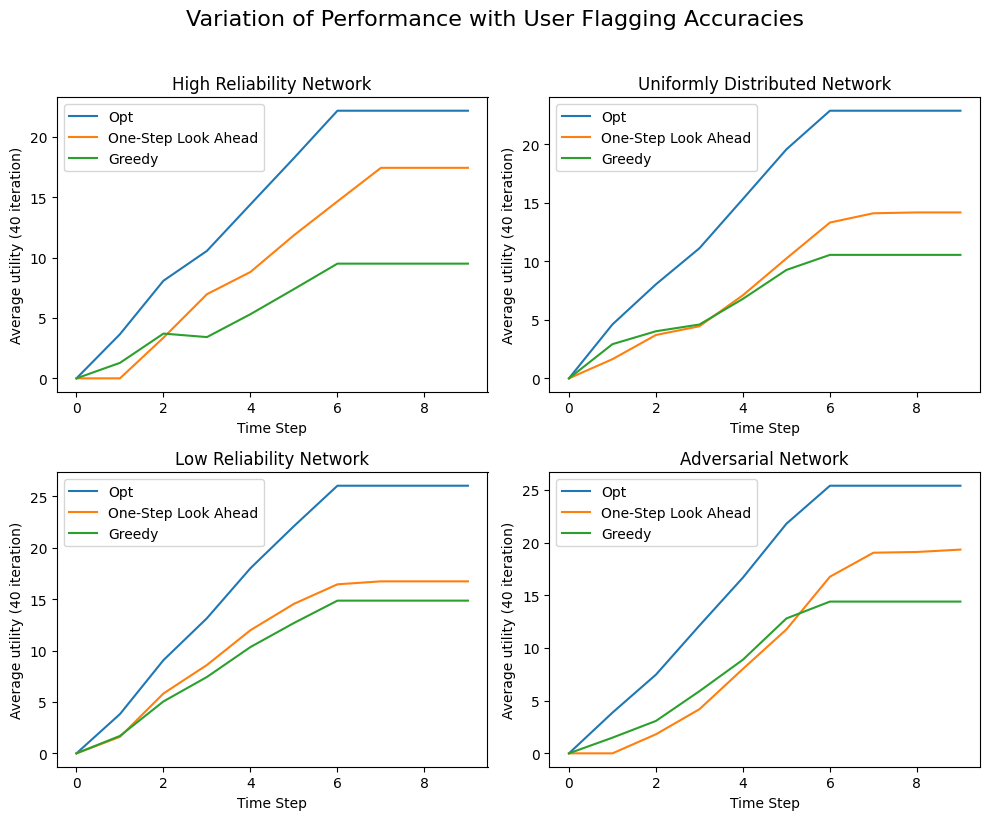

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(10,8))
names=['high','avg','low','adv']
titles=['High Reliability Network', 'Uniformly Distributed Network', 'Low Reliability Network', 'Adversarial Network']
legends=['Opt','One-Step Look Ahead', 'Greedy']
k=0
for i in range(2):
    for j in range(2):
        for l in range(3):
            ax[i,j].plot(user[names[k]][l],label=legends[l])
            ax[i,j].set_xlabel('Time Step')
            ax[i,j].set_ylabel('Average utility (40 iteration)')
            ax[i,j].legend()
        ax[i,j].set_title(titles[k])
        k+=1
plt.suptitle('Variation of Performance with User Flagging Accuracies',fontsize=16,y=1.02)
fig.tight_layout()
plt.show()

In [ ]:
import pickle
with open('/content/drive/My Drive/BTP_variables.pkl','rb') as file:
    loader=pickle.load(file)

In [ ]:
user=loader.copy()

In [ ]:
user['high']=[u_1,u_2,u_3].copy()

In [ ]:
print(user.keys())

dict_keys(['avg', 'low', 'adv'])


In [ ]:
import pickle
# with open('/content/drive/My Drive/BTP_variables.pkl', 'rb') as file:
#     loaded = pickle.load(file)
# # loaded['user']=user
with open('/content/drive/My Drive/BTP_variables.pkl', 'wb') as file:
    pickle.dump(user, file)

In [ ]:
titles=['Reliable Network', 'Equal Distribution', '10% High Reliable', 'Adversarial Network']

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(dic_1)

{8: [array([ 0.        ,  4.39914624, 10.71912864, 17.00045472, 23.3961504 ,
       28.22379264, 32.23577664, 32.23577664, 32.23577664, 32.23577664]), array([ 0.       ,  0.0684   ,  2.40804  ,  7.060488 , 13.4734944,
       19.0361472, 23.6710224, 27.1383024, 27.1383024, 27.1383024]), array([ 0.        ,  2.89914624,  8.39412864, 13.47545472, 18.7461504 ,
       22.22379264, 24.58577664, 24.58577664, 24.58577664, 24.58577664])]}


In [ ]:
print(dic_3)

{7: [array([ 0.        ,  1.83582528,  3.6494784 ,  5.04939264,  6.42523584,
        8.59220352, 11.11919232, 11.11919232, 11.11919232, 11.11919232]), array([ 0.       ,  0.       ,  2.1697536,  3.8276448,  5.2147104,
        6.608832 ,  8.6908512, 10.733952 , 10.765152 , 10.765152 ]), array([0.        , 0.52009728, 1.7887584 , 2.70574464, 3.98597184,
       5.87698752, 8.27164032, 8.83564032, 8.88244032, 8.88244032])], 8: [array([ 0.        ,  2.44946381,  4.25746253,  6.7242071 ,  8.44956672,
       11.09033741, 13.2095136 , 13.2095136 , 13.2095136 , 13.2095136 ]), array([ 0.        ,  0.        ,  1.71341184,  3.07034304,  5.0932032 ,
        7.03533888,  9.207408  , 11.03221248, 11.10224448, 11.10224448]), array([0.        , 0.97480781, 2.02839053, 3.3530711 , 4.78159872,
       6.46928141, 8.0161056 , 8.6357856 , 8.6669856 , 8.6669856 ])], 6: [array([0.      , 0.653376, 0.892768, 1.399528, 1.889216, 2.628864,
       3.218352, 3.218352, 3.218352, 3.218352]), array([0.     , 0.     

In [ ]:
var={'gamma=2.5': dic,'gamma=1.5': dic_1,'gamma=3.5': dic_3}

In [ ]:
import pickle

# Your variables

# Save to a file
with open('/content/drive/My Drive/BTP_variables.pkl', 'wb') as file:
    pickle.dump(var, file)

In [ ]:
import pickle
with open('/content/drive/My Drive/BTP_variables.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Now, you can access your variables from loaded_data
dic_1 = loaded_data['gamma=1.5']
dic= loaded_data['gamma=2.5']

In [ ]:
print(some_variable)

{8: [array([ 0.        ,  4.39914624, 10.71912864, 17.00045472, 23.3961504 ,
       28.22379264, 32.23577664, 32.23577664, 32.23577664, 32.23577664]), array([ 0.       ,  0.0684   ,  2.40804  ,  7.060488 , 13.4734944,
       19.0361472, 23.6710224, 27.1383024, 27.1383024, 27.1383024]), array([ 0.        ,  2.89914624,  8.39412864, 13.47545472, 18.7461504 ,
       22.22379264, 24.58577664, 24.58577664, 24.58577664, 24.58577664])], 7: [array([ 0.       ,  6.3233792, 10.90368  , 15.3434368, 20.7085984,
       26.4266368, 32.428624 , 32.428624 , 32.428624 , 32.428624 ]), array([ 0.      ,  0.      ,  6.717808, 10.484752, 14.97696 , 18.659008,
       23.398448, 27.881648, 27.881648, 27.881648]), array([ 0.       ,  5.3233792,  8.50368  , 11.5434368, 15.8585984,
       20.8266368, 25.778624 , 25.778624 , 25.778624 , 25.778624 ])], 6: [array([ 0.      ,  2.846128,  5.144928,  8.363904, 11.866144, 15.372224,
       17.267184, 17.267184, 17.267184, 17.267184]), array([ 0.     ,  0.     ,  2.498

In [ ]:
# iter=20
# layers=8
# diff_prob=0.6
# beta=0.6
# gamma=2.5

dic_3[6]=[u_1,u_2,u_3].copy()

In [ ]:
print(dic_3[8])

[array([ 0.        ,  2.44946381,  4.25746253,  6.7242071 ,  8.44956672,
       11.09033741, 13.2095136 , 13.2095136 , 13.2095136 , 13.2095136 ]), array([ 0.        ,  0.        ,  1.71341184,  3.07034304,  5.0932032 ,
        7.03533888,  9.207408  , 11.03221248, 11.10224448, 11.10224448]), array([0.        , 0.97480781, 2.02839053, 3.3530711 , 4.78159872,
       6.46928141, 8.0161056 , 8.6357856 , 8.6669856 , 8.6669856 ])]


In [ ]:
print(dic_1[7])

[array([ 0.        ,  3.52987947,  7.66537579, 11.81038144, 15.6605504 ,
       20.01835349, 23.16988245, 23.16988245, 23.16988245, 23.16988245]), array([ 0.        ,  0.        ,  2.68887467,  5.29145493,  8.87944213,
       12.16097707, 15.0500992 , 16.65444053, 16.6591072 , 16.6591072 ]), array([ 0.        ,  1.3632128 ,  3.41070912,  5.88904811,  7.56788373,
       10.08768683, 10.23454912, 10.23454912, 10.23454912, 10.23454912])]


In [ ]:
import pickle
with open('/content/drive/My Drive/BTP_variables.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Now, you can access your variables from loaded_data
# dic_1 = loaded_data['gamma=1.5']
# dic= loaded_data['gamma=2.5']
# dic_3=loaded_data['gamma=3.5']

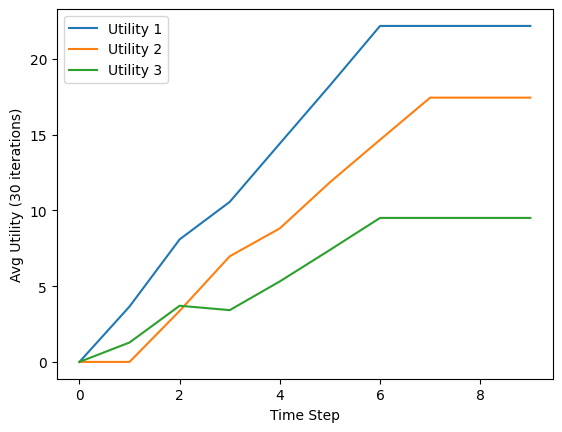

In [ ]:
import matplotlib.pyplot as plt
plt.plot(u_1, label='Utility 1')
plt.plot(u_2, label='Utility 2')
plt.plot(u_3, label='Utility 3')

plt.xlabel('Time Step')
plt.ylabel('Avg Utility (30 iterations)')
plt.legend()
plt.show()

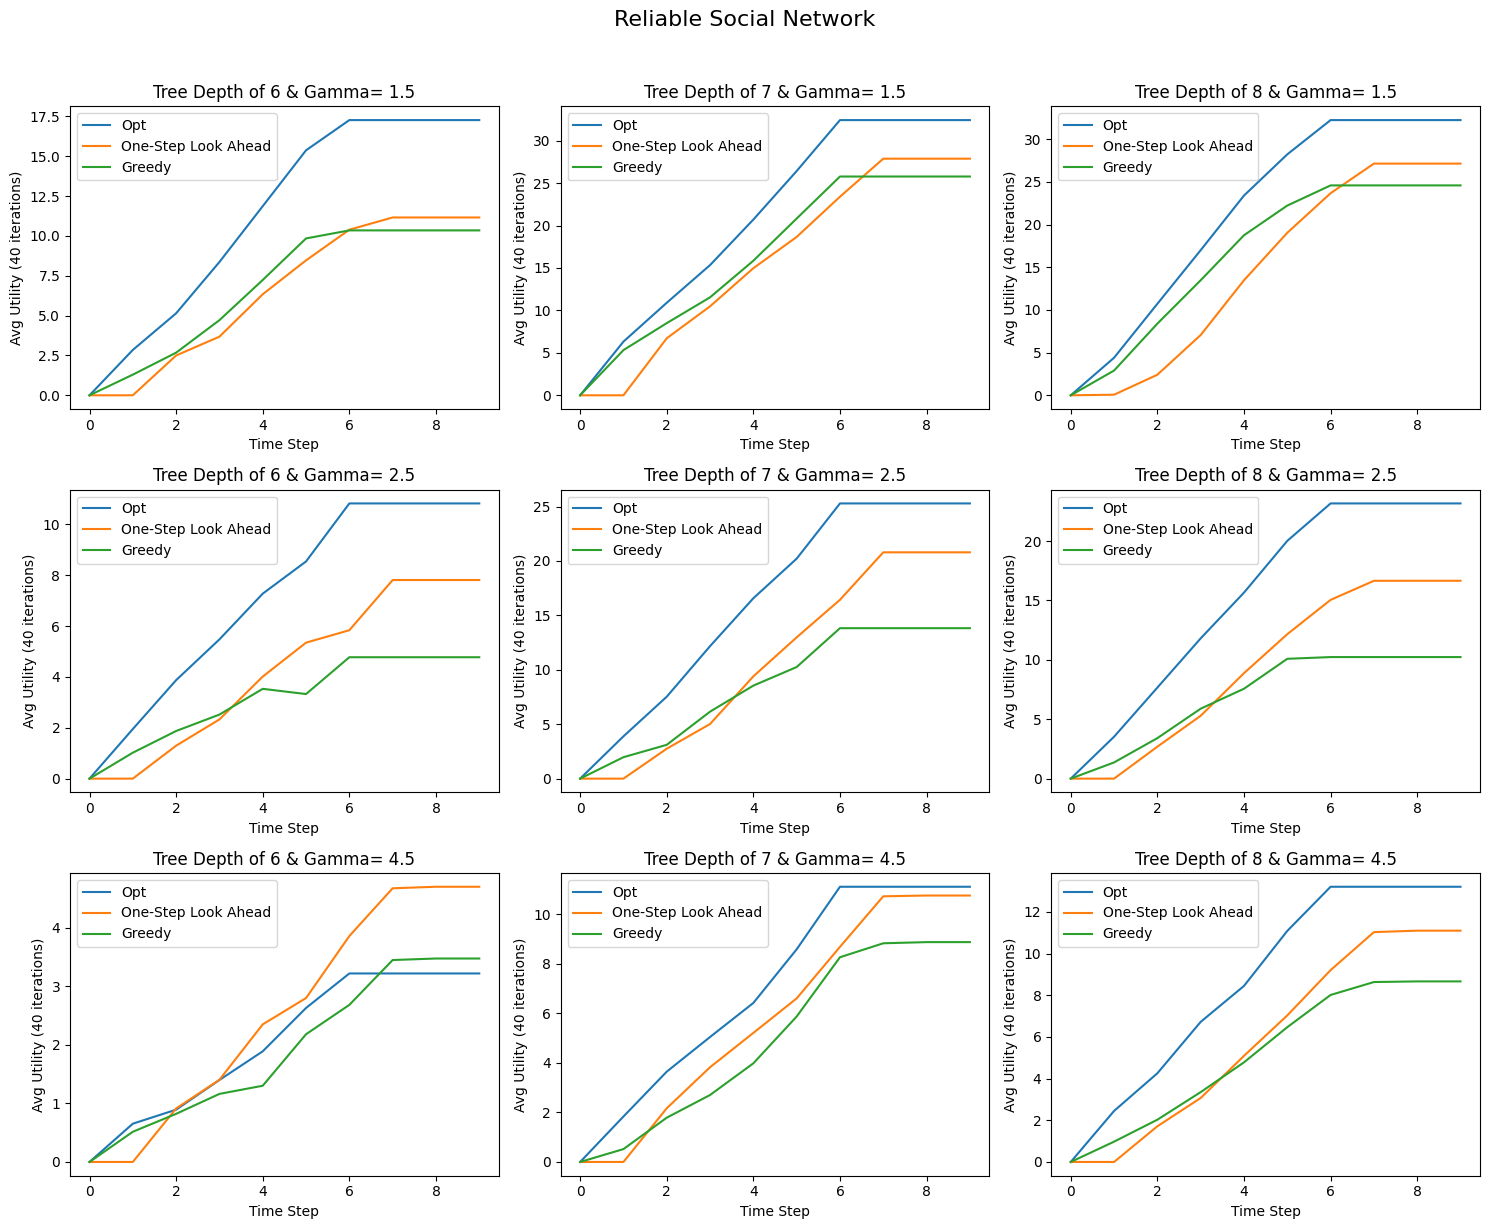

In [ ]:
depth=['6','7','8']
gamma=['1.5','2.5','4.5']
legends=['Opt','One-Step Look Ahead', 'Greedy']
dictionary=[dic_1,dic,dic_3]
fig,ax=plt.subplots(3,3,figsize=(15,12))
for i in range(3):
    for j in range(3):
        for k in range(3):
            ax[i,j].plot(dictionary[i][int(depth[j])][k],label=legends[k])
        ax[i,j].set_xlabel('Time Step')
        ax[i,j].set_ylabel('Avg Utility (40 iterations)')
        ax[i,j].set_title('Tree Depth of ' + depth[j] + ' & Gamma= ' + gamma[i])
        ax[i,j].legend()
plt.suptitle('Reliable Social Network',fontsize=16,y=1.02)
fig.tight_layout()
plt.show()

